# Investigate human positive control matches to see what the distributions of similarity look like and to make sure the most similar matches make sense

Below, we compare three human proteins (IL10, EIFS1, IL18BP) against all other proteins in the human proteome.
Our goal is to see what a normal distribution of alignment TM-scores looks like and to determine whether alignment TM-scores appropriately pull out reasonably similar proteins.
For example, we would expect that IL10 would have similarity to other interleukins or interferons (both of which are in the cytokine family and arose from gene family expansions during the course of evolution).
In contrast, EIFS1 does not have similar proteins, so we would expect relatively few high-alignment TM-score matches.

## TL;DR

We find unexpectedly high similarity arising from very short alignment lengths.
When we filter alignment length to between 50 and 60 amino acids, these alignments drop out, and we see proteins that we would expect to have structural homology with our query proteins.
The cut-off of 50 amino acid alignment length works well for EIF2S1 and IL18BP.
The cut-off of 60 amino acid alignment length works well for IL10.
The relatively longer cutoff for IL10 may have something to do with the gene family expansion for these proteins in the human genome, but that would suggest that the short alignment length matches aren't completely spurious.

These results lead me to initially recommend that we reject viral hits shorter than 50-60 amino acids in length, or that we investigate these more stringently either by visualizing the alignments or through more stringent comparison tools like DALI (although I have not tried DALI for this use case so we would need to experiment more).
While some of these viral alignments might be real, my initial thought that is allowing shorter alignment lengths will increase false positives more than minimizing false negatives.

## Documenting exact foldseek commands

The human structures are alphafold structures downloaded for canonical UniProt human proteomes.
We use the structures downloaded by the `viral.snakefile` in the root of this repository.
The 3 structures in `human_pos_controls` correspond to human IL10, EIFS1, and IL18BP.

We use foldseek as downloaded by conda.
Foldseek version:
`foldseek                  9.427df8a       pl5321h8ec77f5_1    bioconda`

```bash
foldseek easy-search human_pos_controls ../human/host_proteome_pdb_structures human-pos-controls-v-all-human-tmalignfast0-exacttmscore0.tsv tmp_foldseek --tmscore-threshold 0.0 --exhaustive-search 1 -e inf --tmalign-fast 0 --exact-tmscore 0 --alignment-type 1 --format-output query,target,qlen,tlen,alnlen,alntmscore,qtmscore,ttmscore,lddt,prob,qcov,tcov,pident,bits,evalue,cigar,qseq,tseq,qstart,qend,tstart,tend,qaln,taln --format-mode 4
```


In [2]:
setwd("..")

In [181]:
library(tidyverse)
library(ggrepel)

In [182]:
human_metadata <- read_csv("outputs/metadata/human_metadata_combined.csv", show_col_types = FALSE) %>%
  select(uniprot, uniprot_gene_names_primary, uniprot_function_cc) %>%
  distinct()

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


In [183]:
human_vs_human_distribtion <- read_tsv("outputs/viral/positive_control_tests/human-pos-controls-v-all-human-tmalignfast0-exacttmscore0.tsv",
                                       show_col_types = FALSE) %>%
  mutate(query = str_remove(string = query, pattern = ".pdb"),
         target = str_remove(string = target, pattern = ".pdb")) %>%
  left_join(human_metadata, by = c("query" = "uniprot")) %>%
  rename(query_name = uniprot_gene_names_primary, query_function = uniprot_function_cc) %>%
  left_join(human_metadata, by = c("target" = "uniprot")) %>%
  rename(target_name = uniprot_gene_names_primary, target_function = uniprot_function_cc) %>%
  select(query, query_name, target, target_name, target_function, qlen, tlen, alnlen, alntmscore, qtmscore, ttmscore, 
         lddt, qcov, tcov, pident, bits, evalue, qstart, qend, tstart, tend) %>%
  mutate(tmraw1 = qtmscore * qlen,
         tmraw2 = ttmscore * tlen,
         tmraw = (tmraw1 + tmraw2) / 2,
         alntmscore = tmraw/alnlen)

In [184]:
human_vs_human_distribution_exact <- read_tsv("outputs/viral/positive_control_tests/human-pos-controls-v-all-human-tmalignfast0-exacttmscore1.tsv",
                                              show_col_types = FALSE) %>%
  mutate(query = str_remove(string = query, pattern = ".pdb"),
         target = str_remove(string = target, pattern = ".pdb")) %>%
  left_join(human_metadata, by = c("query" = "uniprot")) %>%
  rename(query_name = uniprot_gene_names_primary, query_function = uniprot_function_cc) %>%
  left_join(human_metadata, by = c("target" = "uniprot")) %>%
  rename(target_name = uniprot_gene_names_primary, target_function = uniprot_function_cc) %>%
  select(query, query_name, target, target_name, target_function, qlen, tlen, alnlen, alntmscore, qtmscore, ttmscore, 
         lddt, qcov, tcov, pident, bits, evalue, qstart, qend, tstart, tend) %>%
  mutate(tmraw1 = qtmscore * qlen,
         tmraw2 = ttmscore * tlen,
         tmraw = (tmraw1 + tmraw2) / 2,
         alntmscore = tmraw/alnlen)

## Look at just the first set of results

In [185]:
eif2s1 <- human_vs_human_distribtion %>%
 filter(query_name == "EIF2S1")

il10 <- human_vs_human_distribtion %>%
 filter(query_name == "IL10")

il18bp <- human_vs_human_distribtion %>%
 filter(query_name == "IL18BP")

### EIF2S1

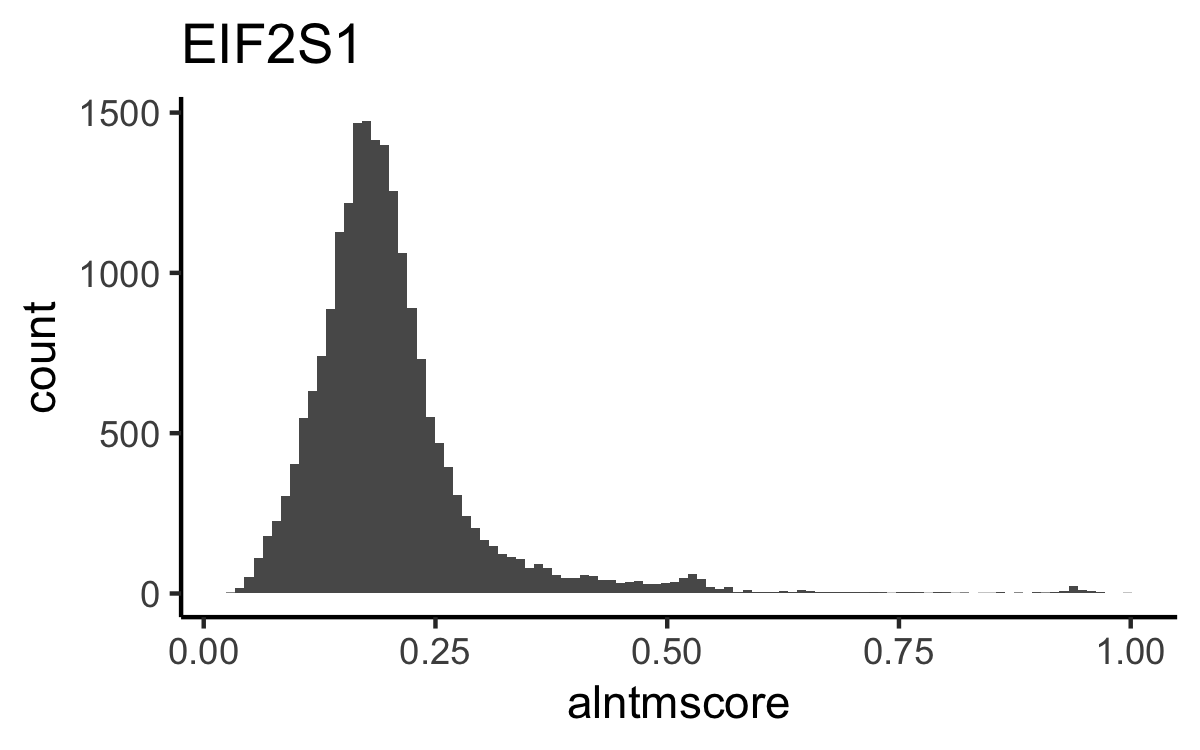

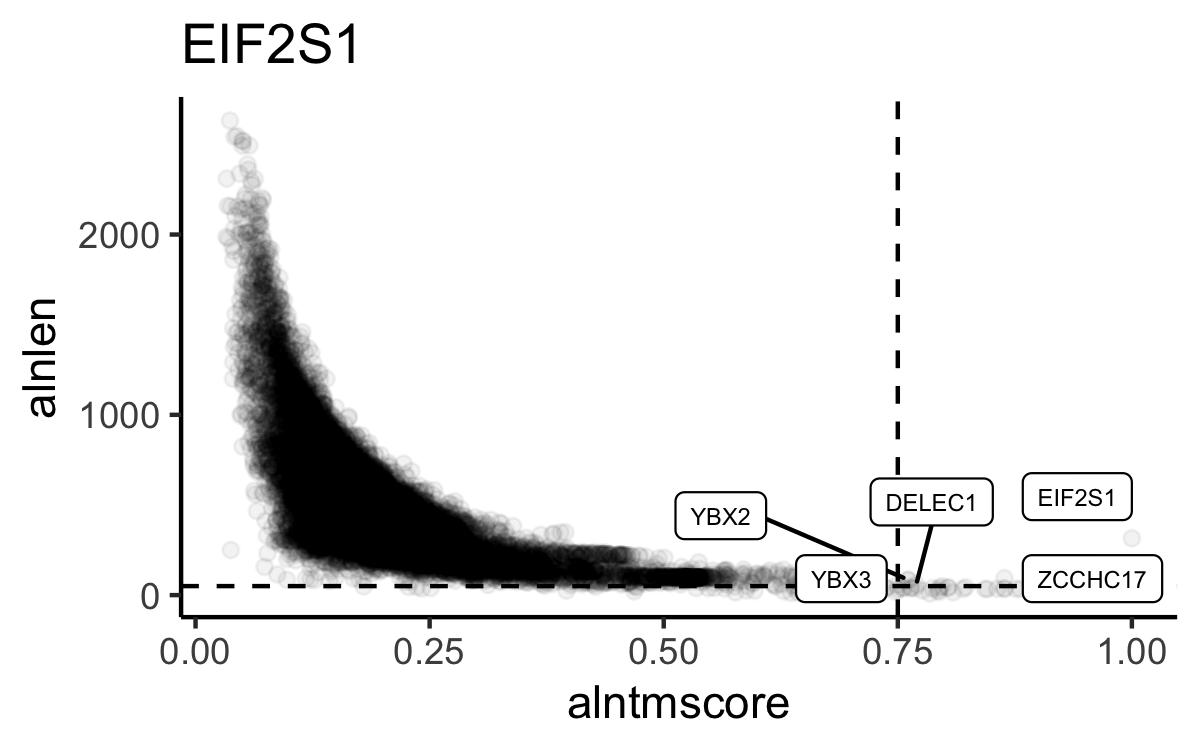

In [223]:
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 300)

ggplot(eif2s1, aes(x = alntmscore)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  #scale_y_log10() +
  labs(title = "EIF2S1")

ggplot(eif2s1, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .05) +
  geom_vline(xintercept = 0.75, linetype = "dashed") +
  geom_hline(yintercept = 50, linetype = "dashed") +
  theme_classic() +
  labs(title = "EIF2S1") +
  geom_label_repel(data = subset(eif2s1 %>% filter(alnlen > 50), alntmscore > 0.75), aes(y = alnlen, label = target_name),
                   max.overlaps = 100, size = 2) 

### IL10

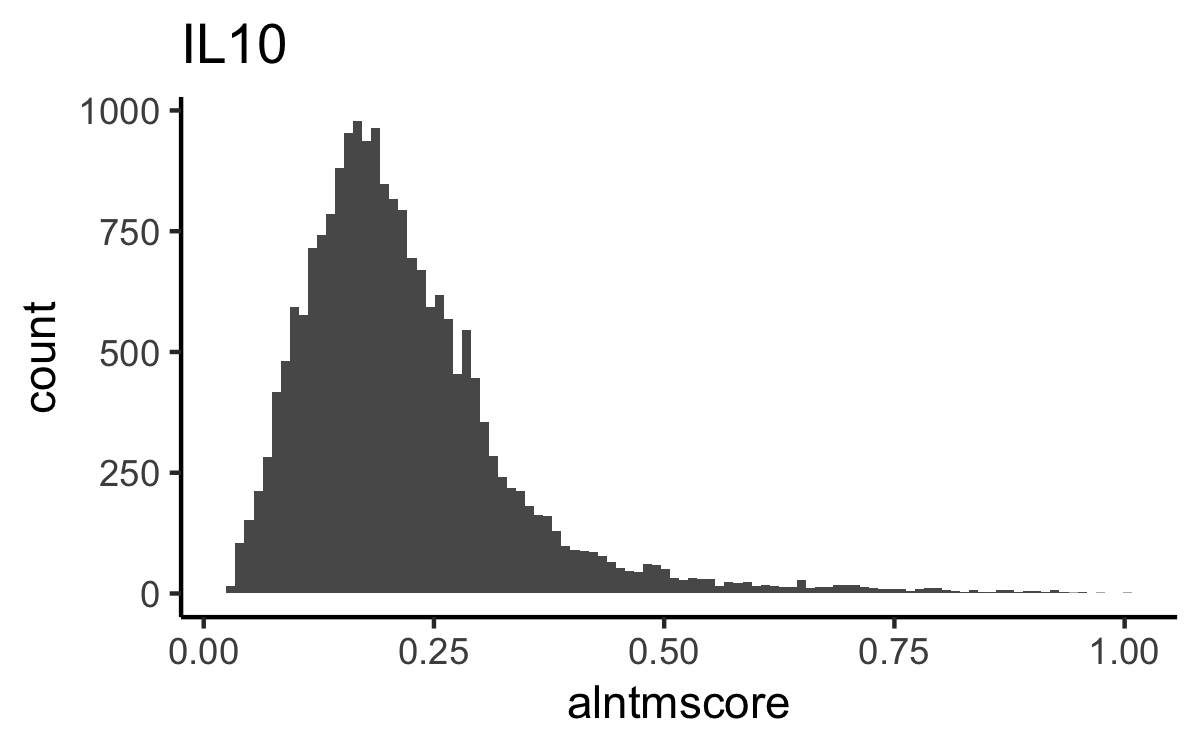

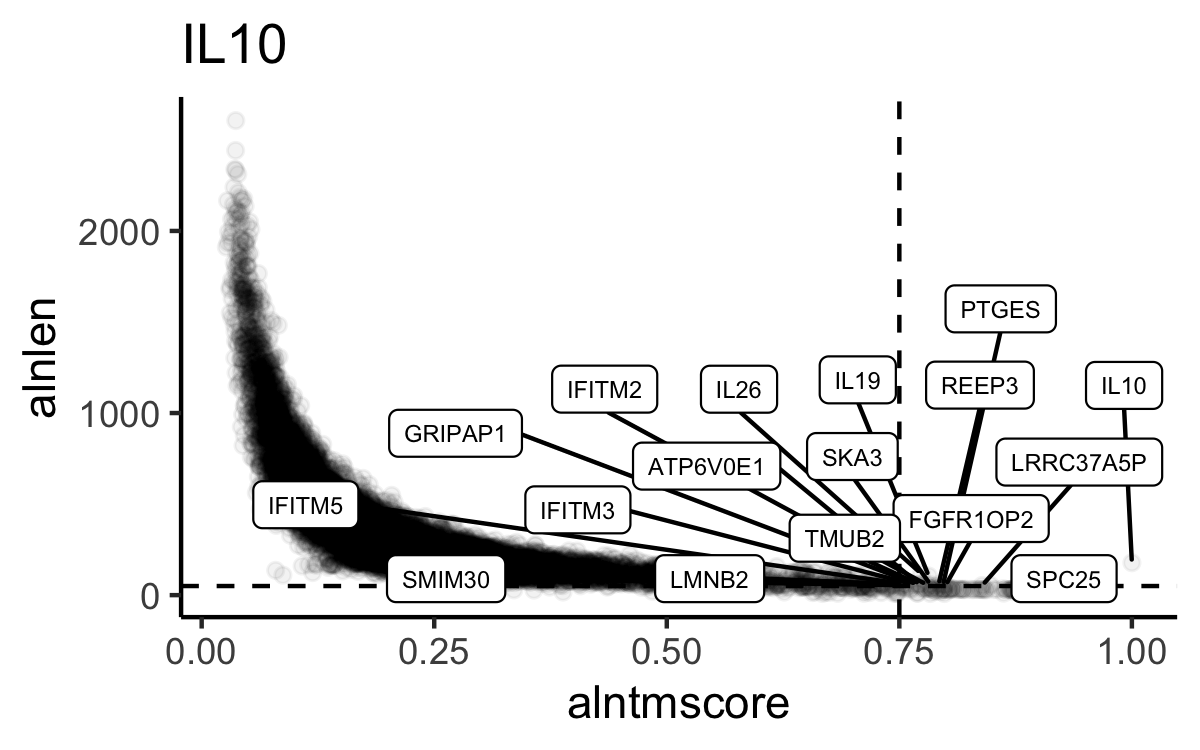

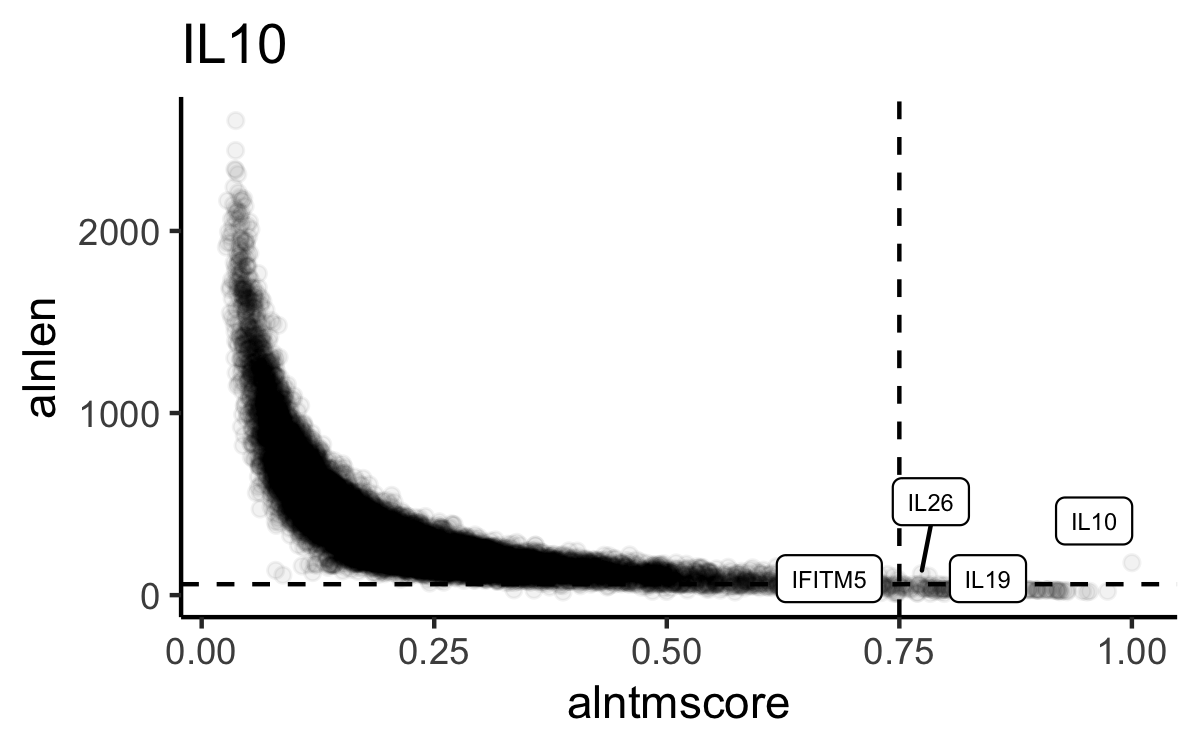

In [210]:
ggplot(il10, aes(x = alntmscore)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  labs(title = "IL10")

ggplot(il10, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .05) +
  geom_hline(yintercept = 50, linetype = "dashed") +
  geom_vline(xintercept = 0.75, linetype = "dashed") +
  theme_classic() +
  labs(title = "IL10") +
  geom_label_repel(data = subset(il10 %>% filter(alnlen > 50), alntmscore > 0.75), aes(y = alnlen, label = target_name),
                   max.overlaps = 100, size = 2)

# Increasing alignment  length from 50 to 60 makes the short but high TM-score matches much more believable
ggplot(il10, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .05) +
  geom_hline(yintercept = 60, linetype = "dashed") +
  geom_vline(xintercept = 0.75, linetype = "dashed") +
  theme_classic() +
  labs(title = "IL10") +
  geom_label_repel(data = subset(il10 %>% filter(alnlen > 60), alntmscore > 0.75), aes(y = alnlen, label = target_name),
                   max.overlaps = 100, size = 2)

### IL18BP

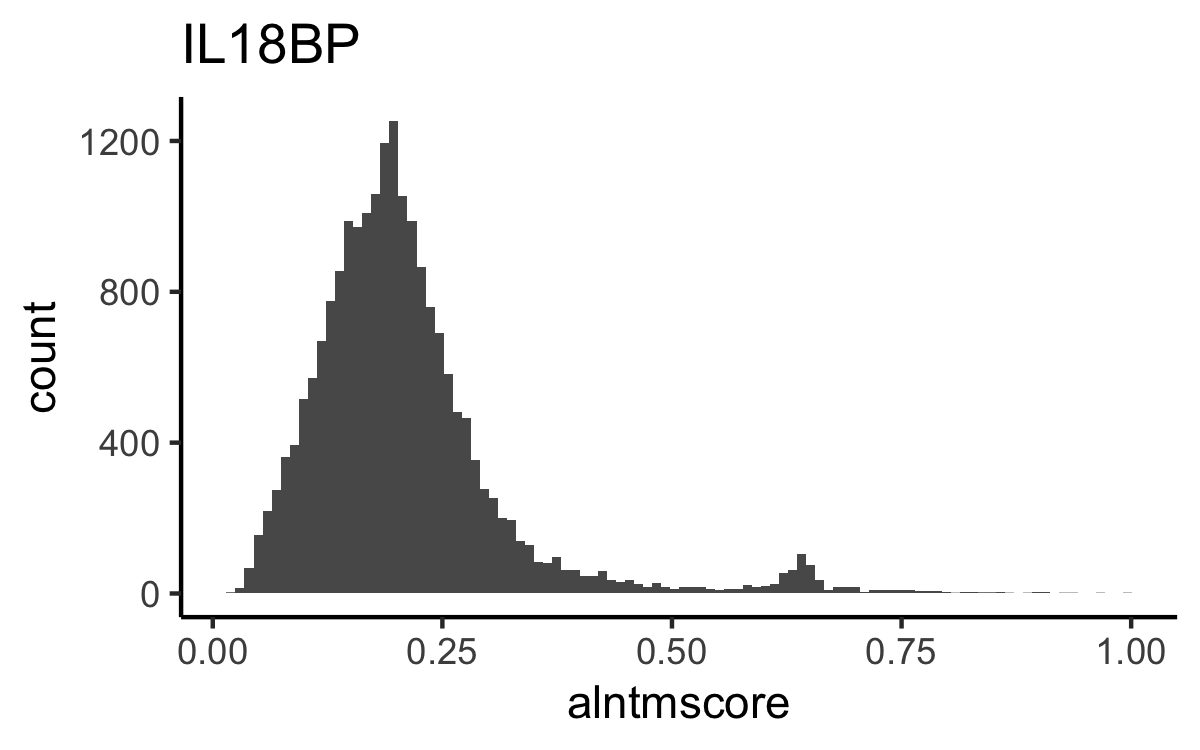

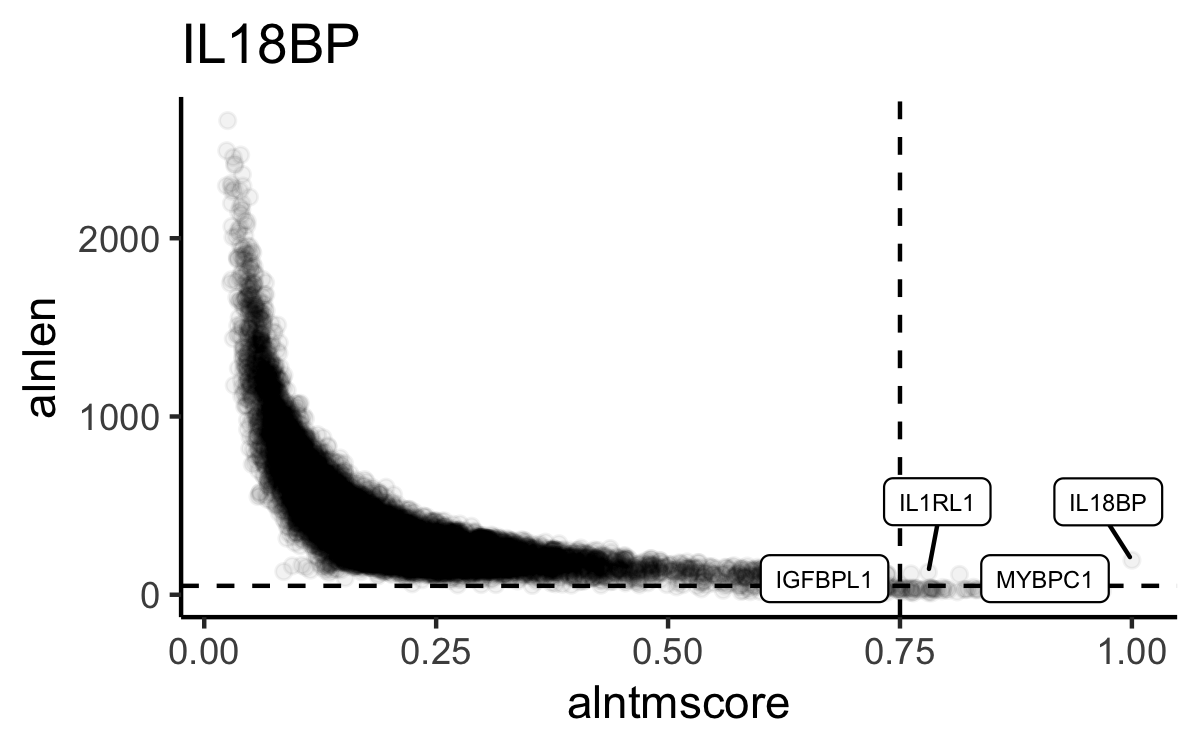

In [219]:
ggplot(il18bp, aes(x = alntmscore)) +
  geom_histogram(bins = 100) +
  theme_classic() +
  labs(title = "IL18BP")

ggplot(il18bp, aes(x = alntmscore, y = alnlen)) +
  geom_point(alpha = .05) +
  geom_hline(yintercept = 50, linetype = "dashed") +
  geom_vline(xintercept = 0.75, linetype = "dashed") +
  theme_classic() +
  labs(title = "IL18BP") +
  geom_label_repel(data = subset(il18bp %>% filter(alnlen > 50), alntmscore > 0.75), aes(y = alnlen, label = target_name),
                   max.overlaps = 100, size = 2)

IL1R1 and IGFBPL1 both make sense as matches to IL18BP, but MYBPC1 less so.
However, pulling out the match below, they match over very similar places in the protein (around 60-160 aa), and the match is for 114 amino acids.
I think this might be a real match, but we would need to investigate more -- particularly because the LDDT isn't that high.
Looking at the alignment in foldmason, it does appear that this is a real match that we would want pulled out.

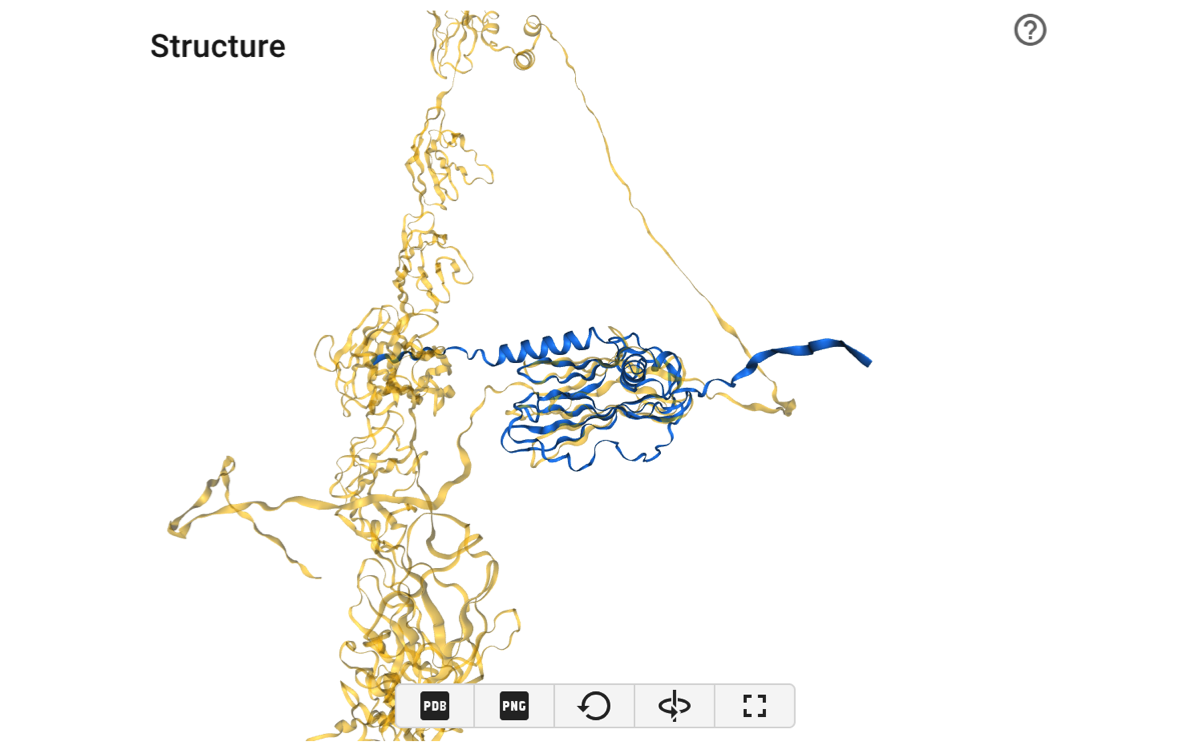

In [221]:
library(png)
img <- readPNG("~/Desktop/foldmason.png")
grid::grid.raster(img)

In [218]:
il18bp %>% filter(target_name == "MYBPC1") %>% select(-tmraw1, -tmraw2, -tmraw)

query,query_name,target,target_name,target_function,qlen,tlen,alnlen,alntmscore,qtmscore,⋯,lddt,qcov,tcov,pident,bits,evalue,qstart,qend,tstart,tend
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
O95998,IL18BP,Q00872,MYBPC1,"FUNCTION: Thick filament-associated protein located in the crossbridge region of vertebrate striated muscle a bands. Slow skeletal protein that binds to both myosin and actin (PubMed:31025394, PubMed:31264822). In vitro, binds to native thin filaments and modifies the activity of actin-activated myosin ATPase. May modulate muscle contraction or may play a more structural role. {ECO:0000269|PubMed:31025394, ECO:0000269|PubMed:31264822}.",194,1141,114,0.8141281,0.4533,⋯,0.5601,0.567,0.095,8.7,43,0.2618,60,169,53,160


In [222]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] png_0.1-8       ggrepel_0.9.5   lubridate_1.9.3 forcats_1.0.0  
 [5] stringr_1.5.1   dplyr_1.1.4     purrr_1.0.2     readr_2.1.5    
 [9] tidyr_1.3.1     tibble_3.2.1    ggplot2_3.5.1   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] bit_4.0.5         gtable_0.3.5      jsonlite_1.8.8    compiler_4.3.3   
 [5] crayon_1.5.2      Rcpp_1.0.12       tidyselect_1.2.0  IRdisplay_1.1    
 [9] parallel_4.3.3    scales_1.3.0      uuid_1.2-0        fastmap_1.1.1    
[13] IRker